In [1]:
import os 
import numpy as np
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from collections import defaultdict
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
seed = 123
np.random.seed(seed)
data_dir = "/kaggle/input/ecg-parse-data"

xtest_path = os.path.join(data_dir, 'X_test.npy')
ytest_path = os.path.join(data_dir, 'Y_test.npy')

X_test = np.load(xtest_path)
Y_test = np.load(ytest_path)

model_dir = "/kaggle/input/ecg-train/best_model.pth"

class ECG_Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float).unsqueeze(0), torch.tensor(self.Y[index], dtype=torch.float).unsqueeze(0)
        
    def __len__(self):
        return len(self.X)
        
class ECG_Autoencoder(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dropout):
        super().__init__()
        
        self.conv_encoder = nn.Sequential(
            nn.Conv1d(1, d_model//2, kernel_size=15, padding=7),
            nn.BatchNorm1d(d_model//2),
            nn.GELU(),
            nn.Conv1d(d_model//2, d_model, kernel_size=5, padding=2),
            nn.BatchNorm1d(d_model),
            nn.GELU(),
        )
        
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=d_model,
                dropout=dropout,
                batch_first=True
            ),
            num_layers=num_layers
        )
        
        self.decoder = nn.Sequential(
            nn.Conv1d(d_model, d_model//2, kernel_size=5, padding=2),
            nn.BatchNorm1d(d_model//2),
            nn.GELU(),
            nn.Conv1d(d_model//2, 1, kernel_size=15, padding=7)
        )

    def forward(self, x):
        # x: [B, 1, 1000]
        x = self.conv_encoder(x)  # [B, d_model, 1000]
        
        # Transformer
        x = x.permute(0, 2, 1)  # [B, 1000, d_model]
        x = self.transformer(x)
        x = x.permute(0, 2, 1)  # [B, d_model, 1000]
        
        return self.decoder(x)

def test_model(model, logger, dataloader, scaler):
    model.eval()
    running_loss = defaultdict(float)
    loop = tqdm(dataloader, desc=f"Test", leave=False)
    
    with torch.no_grad():
        for ecg_input, ecg_target in loop:  
            ecg_input = ecg_input.to(device, non_blocking=True)  
            ecg_target = ecg_target.to(device) 
            
            with autocast(dtype=torch.float16, device_type='cuda'):
                denoised_ecgs = model(ecg_input)
                
                total_loss = F.mse_loss(denoised_ecgs, ecg_target)
                #snr_loss = compute_snr_loss(denoised_ecgs, ecg_target)
                #total_loss = 0.5 * snr_loss + 0.5 * mse_loss
            
            running_loss['total_loss'] += total_loss.item()
            #running_loss['mse_loss'] += mse_loss.item()
            #running_loss['snr_loss'] += snr_loss.item()

    
    running_loss = {k: v/len(dataloader) for k, v in running_loss.items()}
    logger.append({
        **running_loss
    })
    
    print(f"Test Loss: {running_loss['total_loss']:.4f} ")
    #print(f"(MSE: {running_loss['mse_loss']:.4f}, SNR: {running_loss['snr_loss']:.2f} dB)")

Test:   0%|          | 0/103 [00:00<?, ?it/s]

Test Loss: 0.0048 


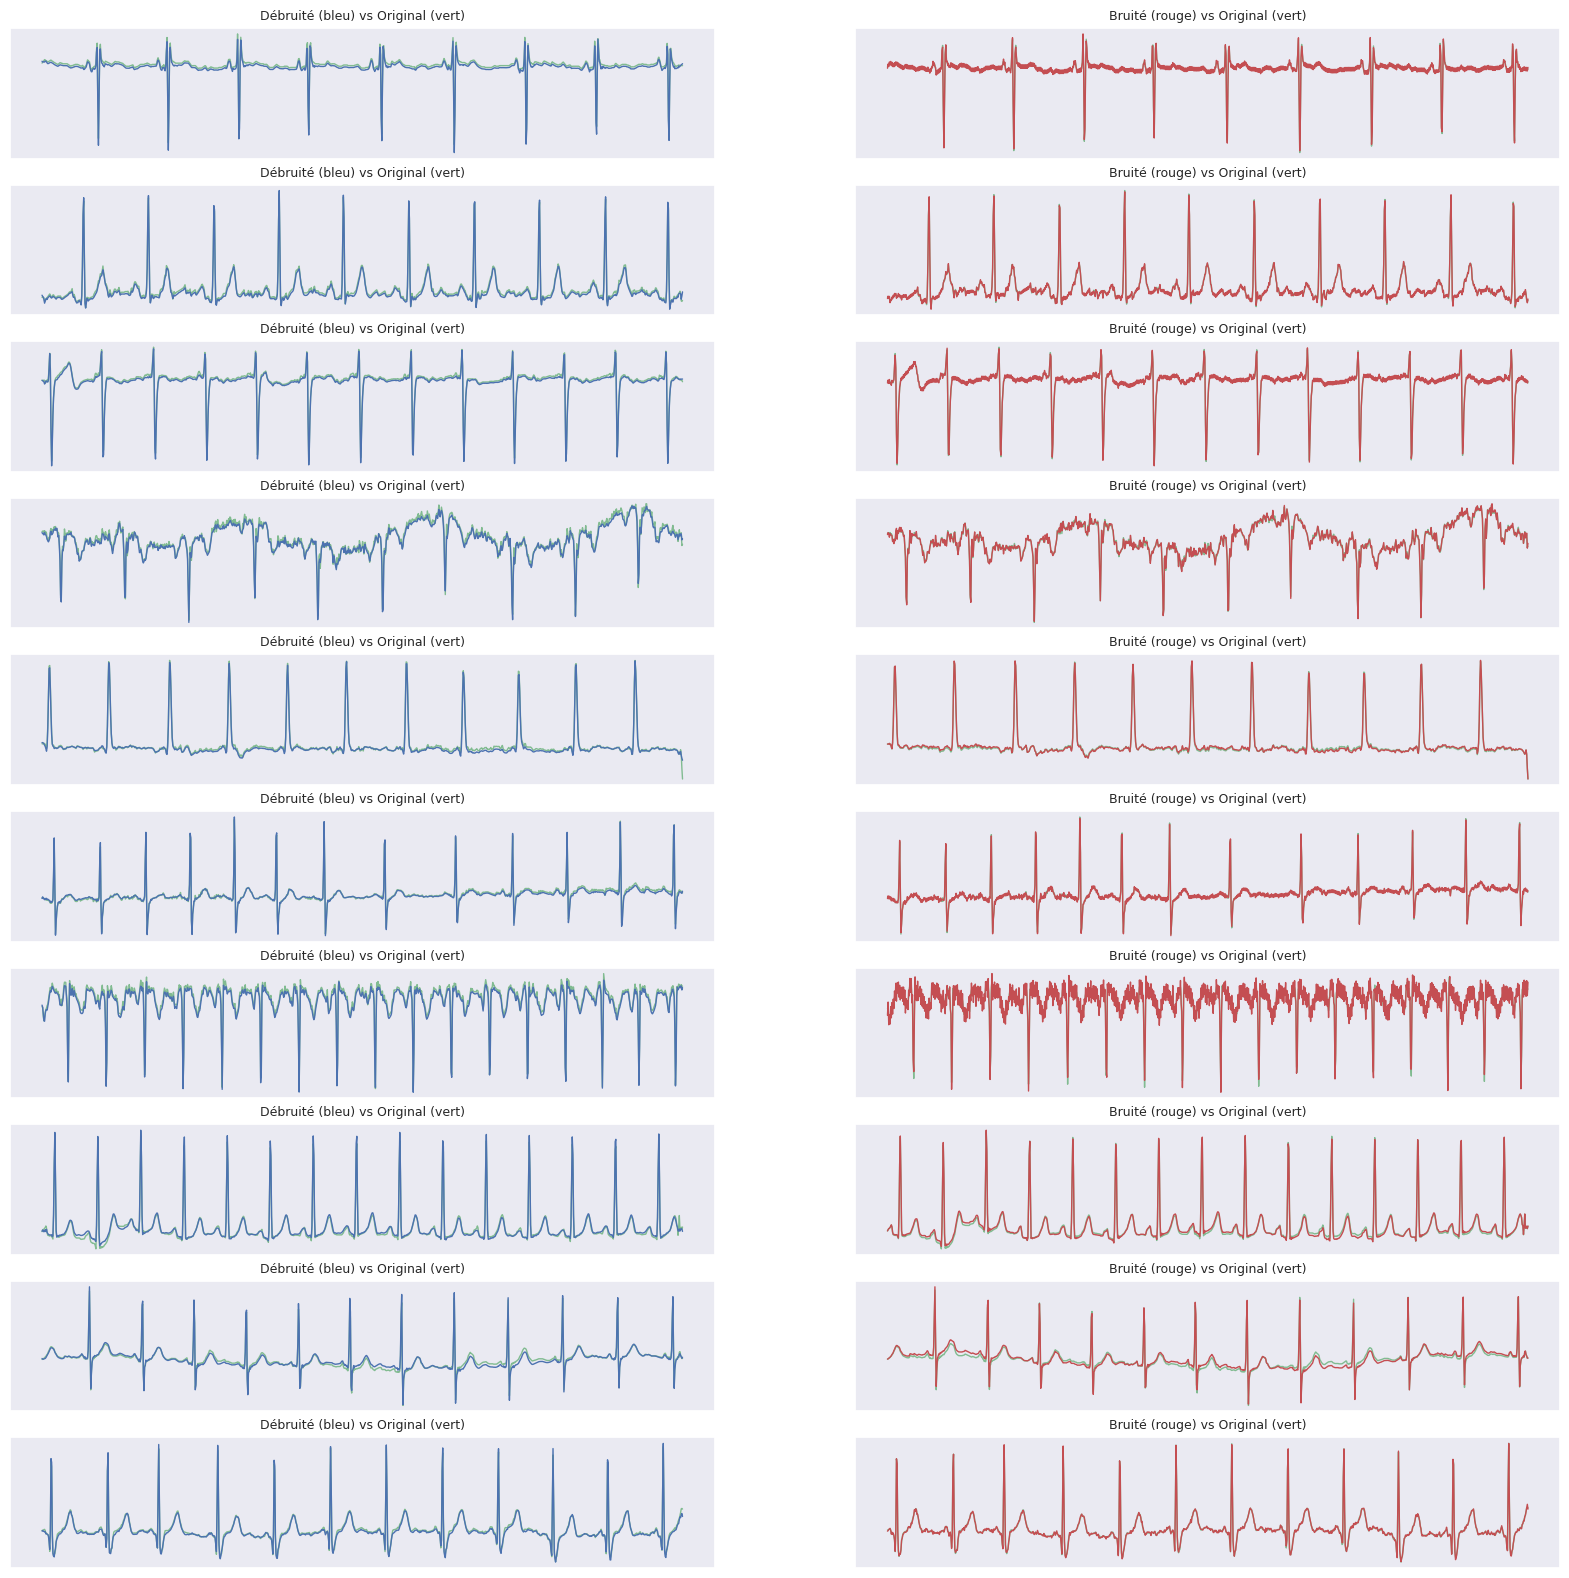

Visualisation sauvegardée sous denoising_comparison.png


In [2]:
def visualize_denoising(model, test_loader, device, n_examples=10, save_path="denoising_comparison.png"):
    model.eval()
    with torch.no_grad():
        all_indices = np.random.choice(len(test_loader.dataset), n_examples, replace=False)
        
        plt.figure(figsize=(20, 20))
        
        for i, idx in enumerate(all_indices):
            noisy_ecg, clean_ecg = test_loader.dataset[idx]
            noisy_ecg = noisy_ecg.unsqueeze(0).to(device)
            
            with autocast(device_type='cuda' if 'cuda' in str(device) else 'cpu'):
                denoised_ecg = model(noisy_ecg).cpu().numpy()
            
            noisy_ecg = noisy_ecg.cpu().numpy().squeeze()
            clean_ecg = clean_ecg.numpy().squeeze()
            denoised_ecg = denoised_ecg.squeeze()
            
            plt.subplot(n_examples, 2, 2*i + 1)
            plt.plot(clean_ecg, 'g-', alpha=0.7, linewidth=1, label='Original')
            plt.plot(denoised_ecg, 'b-', linewidth=1, label='Débruité')
            plt.title("Débruité (bleu) vs Original (vert)", fontsize=9)
            plt.xticks([])
            plt.yticks([])

            plt.subplot(n_examples, 2, 2*i + 2)
            plt.plot(clean_ecg, 'g-', alpha=0.7, linewidth=1, label='Original')
            plt.plot(noisy_ecg, 'r-', linewidth=1)
            plt.title("Bruité (rouge) vs Original (vert)", fontsize=9)
            plt.xticks([])
            plt.yticks([])

        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.show()
        print(f"Visualisation sauvegardée sous {save_path}")

import torch.nn.functional as F

if __name__ == "__main__":
    BATCH_SIZE = 256
    test_ds = ECG_Dataset(X_test, Y_test)
    test_loader = DataLoader(test_ds, num_workers=4, pin_memory=True, batch_size=BATCH_SIZE, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    d_model, n_head, n_layer, dropout = 96, 2, 2, 0.05
    model = ECG_Autoencoder(d_model, n_head, n_layer, dropout)
    model.load_state_dict(torch.load(model_dir, weights_only=True))
    model.to(device)

    scaler = GradScaler()

    test_logger = []
    test_model(model, test_logger, test_loader, scaler)
    visualize_denoising(model, test_loader, device)